<a href="https://colab.research.google.com/github/wenhuipeng/my_project/blob/main/pred_pos_neg_Tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


#import packages

In [2]:
import pandas as pd
import numpy as np

In [114]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow import feature_column
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error # MAE 绝对值误差均值
#from sklearn.preprocessing import Imputer # 数据的预处理，一般是特征缩放和特征编码
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn import preprocessing
import joblib
from sklearn.metrics import accuracy_score
import graphviz
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import pydotplus
from IPython.display import display, Image
from sklearn.ensemble import GradientBoostingClassifier

In [5]:
from xgboost import XGBRegressor
from xgboost import XGBClassifier
import xgboost

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier

In [7]:
from sklearn.ensemble import AdaBoostClassifier

In [103]:
from sklearn import svm
import matplotlib.image as mpimg

In [9]:
!pip install catboost
from catboost import CatBoostClassifier

     |████████████████████████████████| 76.1 MB 1.2 MB/s 


#阅读数据

In [10]:
df=pd.read_csv('/content/drive/MyDrive/MFE project/Credit_Card_Default/data/origin_data/card_train_A.csv',index_col=0)

In [11]:
df.reset_index(drop=True)

ID  LIMIT_BAL  SEX  ...  PAY_AMT5  PAY_AMT6  default.payment.next.month
0      14008    20000.0    2  ...    1831.0    1500.0                           1
1       9823    20000.0    1  ...    2110.0   12996.0                           0
2      23251    60000.0    2  ...    1100.0    1200.0                           0
3        864    10000.0    2  ...     311.0     322.0                           0
4      12522   230000.0    2  ...    5000.0    3000.0                           0
...      ...        ...  ...  ...       ...       ...                         ...
11995  22974   200000.0    2  ...    5000.0    5000.0                           1
11996  11384   110000.0    1  ...    2000.0    3261.0                           0
11997  19795   180000.0    2  ...    3739.0    6547.0                           0
11998  28734   240000.0    2  ...     176.0    1720.0                           0
11999  24753    70000.0    1  ...    3769.0       0.0                           1

[12000 rows x 25 columns]

#处理数据

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 14007 to 24752
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          12000 non-null  int64  
 1   LIMIT_BAL                   12000 non-null  float64
 2   SEX                         12000 non-null  int64  
 3   EDUCATION                   12000 non-null  int64  
 4   MARRIAGE                    12000 non-null  int64  
 5   AGE                         12000 non-null  int64  
 6   PAY_0                       12000 non-null  int64  
 7   PAY_2                       12000 non-null  int64  
 8   PAY_3                       12000 non-null  int64  
 9   PAY_4                       12000 non-null  int64  
 10  PAY_5                       12000 non-null  int64  
 11  PAY_6                       12000 non-null  int64  
 12  BILL_AMT1                   12000 non-null  float64
 13  BILL_AMT2                  

In [13]:
df.describe()

ID      LIMIT_BAL  ...       PAY_AMT6  default.payment.next.month
count  12000.000000   12000.000000  ...   12000.000000                12000.000000
mean   15024.208667  167430.306667  ...    5135.160250                    0.221167
std     8661.196563  130379.490306  ...   18020.552976                    0.415050
min        2.000000   10000.000000  ...       0.000000                    0.000000
25%     7542.750000   50000.000000  ...     153.500000                    0.000000
50%    15091.500000  140000.000000  ...    1500.000000                    0.000000
75%    22557.250000  240000.000000  ...    4000.000000                    0.000000
max    29996.000000  800000.000000  ...  528666.000000                    1.000000

[8 rows x 25 columns]

In [14]:
print(list(df['default.payment.next.month']).count(1))
print(list(df['default.payment.next.month']).count(0))

2654
9346


处理训练和测试数据

In [15]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=2022,stratify=df['default.payment.next.month'])

In [16]:
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default.payment.next.month'],
      dtype='object')

In [17]:
NUMERIC_COLS = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

In [18]:
df_train, df_valid=train_test_split(df_train, test_size=0.2, random_state=2022,stratify=df_train['default.payment.next.month'])

In [19]:
y_train = df_train['default.payment.next.month']  # training label
y_test = df_test['default.payment.next.month']#test label
y_valid=df_valid['default.payment.next.month']
X_train = df_train[NUMERIC_COLS]  # training dataset
X_test = df_test[NUMERIC_COLS]  # testing dataset
X_valid=df_valid[NUMERIC_COLS]

#训练lightGBM模型

In [179]:
my_model = lgb.LGBMClassifier( num_leaves=31, learning_rate=0.01, n_estimators=160,metric='auc',boosting='gbdt',random_state=2022
                              )
#my_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=20)
#my_model.fit(X_train, y_train, eval_set=[(X_test, y_test)])
my_model.fit(X_train, y_train)
y_pred=my_model.predict_proba(X_test)[:,1]
roc_auc_score(y_test,y_pred)

0.7828748164874617

In [180]:
y_predprob_train = my_model.predict_proba(X_train)[:,1]
roc_auc_score(y_train,y_predprob_train)

0.8507411712955908

In [181]:
my_model.feature_importances_

array([477,  26,  77,  47, 211, 290,  57, 103, 233,  38, 127, 229, 255,
       162, 118, 203, 180, 426, 300, 389, 226, 361, 265])

In [177]:
my_model_fi = pd.DataFrame(columns = ['feature', 'importance'])
my_model_fi['feature'] = X_train.columns
my_model_fi['importance'] = my_model.feature_importances_
my_model_fi['importance']=my_model_fi['importance']/my_model_fi['importance'].sum()
my_model_fi.sort_values(by='importance', ascending=False, inplace=True)
my_model_fi.reset_index(drop=True)

feature  importance
0   LIMIT_BAL    0.099375
1    PAY_AMT1    0.088750
2    PAY_AMT3    0.081042
3    PAY_AMT5    0.075208
4    PAY_AMT2    0.062500
5       PAY_0    0.060417
6    PAY_AMT6    0.055208
7   BILL_AMT2    0.053125
8       PAY_4    0.048542
9   BILL_AMT1    0.047708
10   PAY_AMT4    0.047083
11        AGE    0.043958
12  BILL_AMT5    0.042292
13  BILL_AMT6    0.037500
14  BILL_AMT3    0.033750
15      PAY_6    0.026458
16  BILL_AMT4    0.024583
17      PAY_3    0.021458
18  EDUCATION    0.016042
19      PAY_2    0.011875
20   MARRIAGE    0.009792
21      PAY_5    0.007917
22        SEX    0.005417

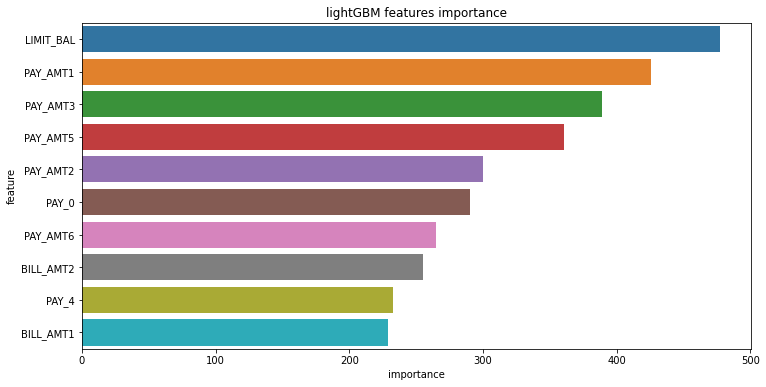

In [178]:
%matplotlib inline
def feature_importances(df, model):
    max_num_features=10
    feature_importances = pd.DataFrame(columns = ['feature', 'importance'])
    feature_importances['feature'] = df.columns
    feature_importances['importance'] = model.feature_importances_
    my_model_fi['importance']=my_model_fi['importance']/my_model_fi['importance'].sum()
    feature_importances.sort_values(by='importance', ascending=False, inplace=True)
    feature_importances = feature_importances[:max_num_features]
    plt.figure(figsize=(12, 6));
    sns.barplot(x="importance", y="feature", data=feature_importances);
    plt.title('lightGBM features importance');
feature_importances(X_train, my_model)

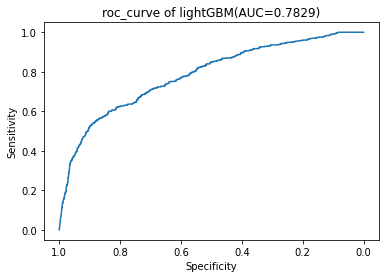

In [171]:
my_model_fpr,my_model_tpr,my_model_threasholds=roc_curve(y_test,y_pred)
plt.title("roc_curve of %s(AUC=%.4f)"%('lightGBM',roc_auc_score(y_test,y_pred)))
plt.xlabel('Specificity')
plt.ylabel('Sensitivity')
plt.plot(list(1-np.array(my_model_fpr)),my_model_tpr)
plt.gca().invert_xaxis()
plt.show()

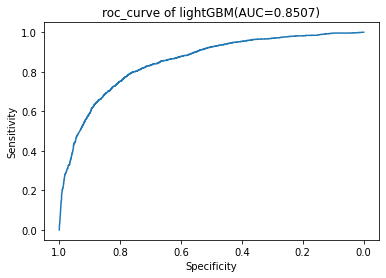

In [172]:
my_model_fpr,my_model_tpr,my_model_threasholds=roc_curve(y_train,y_predprob_train)
plt.title("roc_curve of %s(AUC=%.4f)"%('lightGBM',roc_auc_score(y_train,y_predprob_train)))
plt.xlabel('Specificity')
plt.ylabel('Sensitivity')
plt.plot(list(1-np.array(my_model_fpr)),my_model_tpr)
plt.gca().invert_xaxis()
plt.show()

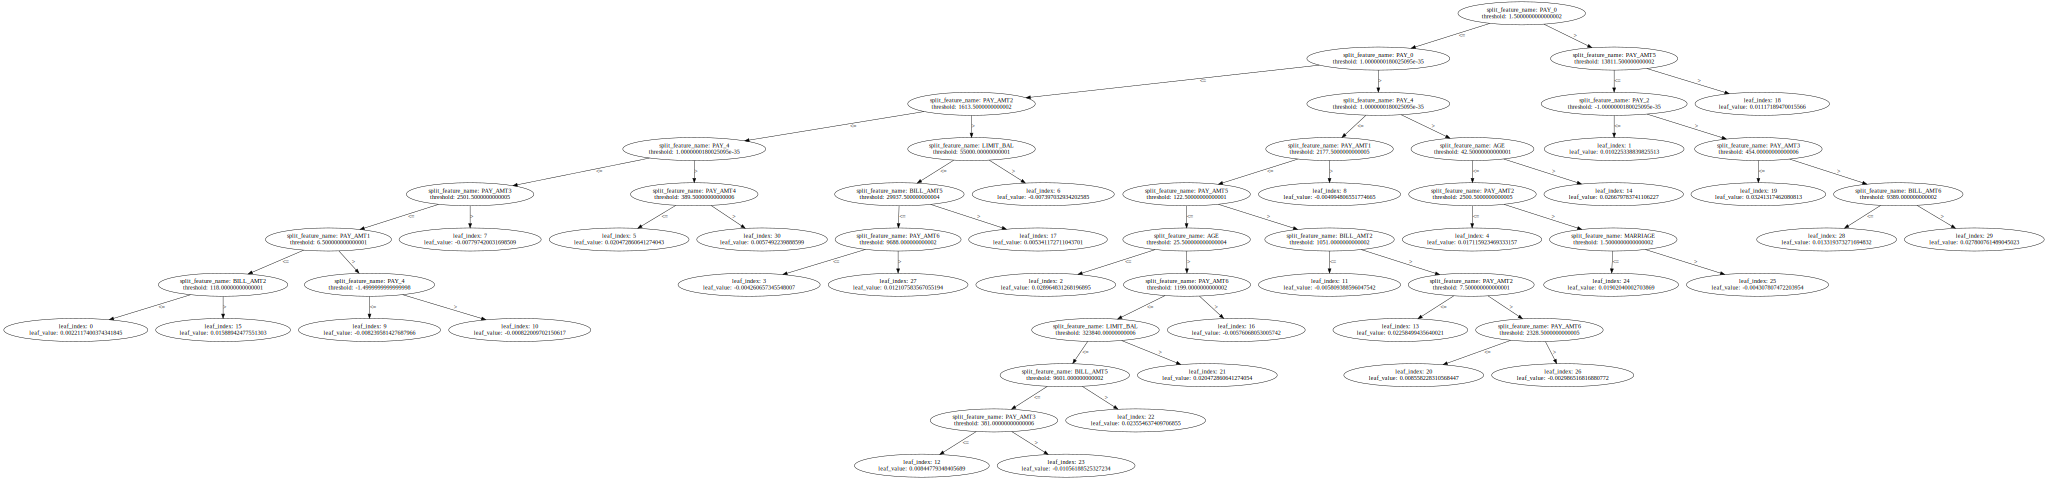

In [ ]:
figure=lgb.create_tree_digraph(my_model,tree_index=1)
graph = graphviz.Source(figure)  
graph

In [ ]:
graph.save()
!dot -Tpng Source.gv >lightGBM_1.png
!cp /content/lightGBM_1.png /content/drive/MyDrive/MFE\ project/Credit_Card_Default/data/model/Tree/pictures/

'Source.gv'

In [ ]:
# 模型存储
joblib.dump(my_model, 'lightGBM.pkl')
# 模型加载
my_model = joblib.load('lightGBM.pkl')

In [ ]:
!cp /content/lightGBM.pkl /content/drive/MyDrive/MFE\ project/Credit_Card_Default/data/model/Tree/

In [ ]:
n_lr_list=[]
for n_lr in [i for i in range(2,200)]:
  my_model_i=lgb.LGBMClassifier(num_leaves=n_lr, learning_rate=0.01, n_estimators=160,metric='auc',boosting='gbdt',random_state=2022)
  my_model_i.fit(X_train, y_train)
  predictions_i = my_model_i.predict_proba(X_test)[:,1]
  n_lr_list.append(roc_auc_score(y_test,predictions_i))

In [ ]:
n_lr_list

[0.7561492444371896,
 0.7697888736738479,
 0.7716509528545331,
 0.772031832686946,
 0.7716549833289502,
 0.7732681807143814,
 0.775003803760231,
 0.7760658337691284,
 0.7777540987405775,
 0.7786040250332766,
 0.7797612750002771,
 0.7811679105718337,
 0.7808963573579838,
 0.7810641258555941,
 0.7812721990973752,
 0.7818052293390323,
 0.7814963942368247,
 0.7823705033760262,
 0.7820435311389415,
 0.7825030052224873,
 0.7827322384549579,
 0.7831509039850308,
 0.7822369939109608,
 0.7829040374269854,
 0.7823664729016091,
 0.7828581907804913,
 0.7826838727619532,
 0.7828158707991121,
 0.7834773724128133,
 0.7828748164874617,
 0.7831206754269027,
 0.7833927324500549,
 0.7835882104592827,
 0.7828612136363041,
 0.78220374249702,
 0.7829861583432333,
 0.7829952269106716,
 0.7821070111110103,
 0.7825241652131768,
 0.7830818821106386,
 0.7823634500457962,
 0.7807190164836327,
 0.7825453252038664,
 0.7817362074646401,
 0.7805315994232391,
 0.7808857773626389,
 0.7787607097262401,
 0.77947057703294

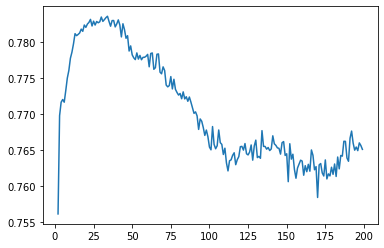

In [ ]:
x=[i for i in range(2,200)]
plt.plot(x,n_lr_list)

In [ ]:
n_lr_list[20:50]

[0.7827322384549579,
 0.7831509039850308,
 0.7822369939109608,
 0.7829040374269854,
 0.7823664729016091,
 0.7828581907804913,
 0.7826838727619532,
 0.7828158707991121,
 0.7834773724128133,
 0.7828748164874617,
 0.7831206754269027,
 0.7833927324500549,
 0.7835882104592827,
 0.7828612136363041,
 0.78220374249702,
 0.7829861583432333,
 0.7829952269106716,
 0.7821070111110103,
 0.7825241652131768,
 0.7830818821106386,
 0.7823634500457962,
 0.7807190164836327,
 0.7825453252038664,
 0.7817362074646401,
 0.7805315994232391,
 0.7808857773626389,
 0.7787607097262401,
 0.7794705770329461,
 0.7782286871031872,
 0.7778195939498548]

#XGBoosting模型

In [161]:
my_xgb = XGBClassifier(objective='binary:logistic',n_estimators=102, learning_rate=0.06,metric='auc',random_state=2022,subsample=0.8,scale_pos_weight=4)
#my_xgb = XGBRegressor(objective='binary:logistic',n_estimators=20, learning_rate=0.2,metric='auc',max_depth=5,min_child_weight=1.1)
#my_xgb = XGBRegressor(objective='reg:linear',n_estimators=34, learning_rate=0.02,metric='auc',max_depth=5)
my_xgb.fit(X_train, y_train,eval_metric='auc')
#print("Validation:",my_xgb.score(X_valid_xgb,y_valid))

y_pred = my_xgb.predict_proba(X_test)[:,1]
#accuracy_score(y_test,y_pred)
roc_auc_score(y_test,y_pred)

0.7831917125385035

In [162]:
y_predprob_train = my_xgb.predict_proba(X_train)[:,1]
roc_auc_score(y_train,y_predprob_train)

0.8141540837668089

In [166]:
my_xgb_fi = pd.DataFrame(columns = ['feature', 'importance'])
my_xgb_fi['feature'] = X_train.columns
my_xgb_fi['importance'] = my_xgb.feature_importances_
my_xgb_fi.sort_values(by='importance', ascending=False, inplace=True)
my_xgb_fi.reset_index(drop=True)

feature  importance
0       PAY_0    0.302344
1       PAY_4    0.076749
2       PAY_3    0.063963
3       PAY_2    0.055935
4   LIMIT_BAL    0.045517
5    PAY_AMT2    0.043075
6    PAY_AMT3    0.040138
7    PAY_AMT1    0.036428
8       PAY_6    0.033544
9       PAY_5    0.031503
10   PAY_AMT4    0.028243
11  BILL_AMT2    0.024399
12  BILL_AMT5    0.023569
13  EDUCATION    0.023413
14  BILL_AMT1    0.022590
15  BILL_AMT3    0.020943
16  BILL_AMT4    0.019513
17   PAY_AMT5    0.018964
18        SEX    0.018642
19  BILL_AMT6    0.018604
20   PAY_AMT6    0.018288
21   MARRIAGE    0.017081
22        AGE    0.016553

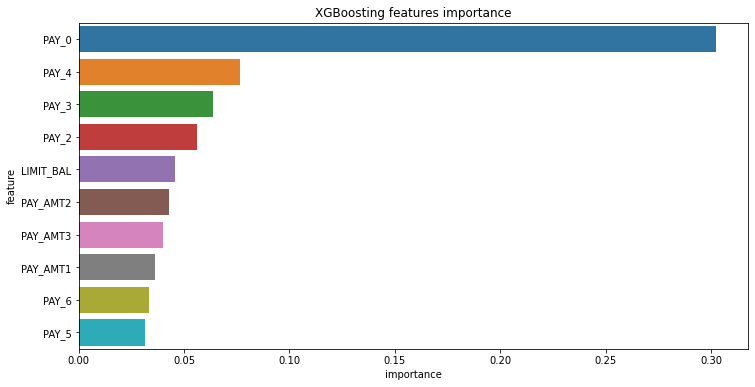

In [176]:
%matplotlib inline
def feature_importances(df, model):
    max_num_features=10
    feature_importances = pd.DataFrame(columns = ['feature', 'importance'])
    feature_importances['feature'] = df.columns
    feature_importances['importance'] = model.feature_importances_
    feature_importances.sort_values(by='importance', ascending=False, inplace=True)
    feature_importances = feature_importances[:max_num_features]
    plt.figure(figsize=(12, 6));
    sns.barplot(x="importance", y="feature", data=feature_importances);
    plt.title('XGBoosting features importance');
feature_importances(X_train, my_xgb)

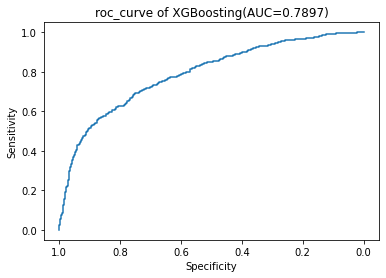

In [164]:
my_xgb_fpr,my_xgb_tpr,my_xgb_threasholds=roc_curve(y_test,y_predprob)
plt.title("roc_curve of %s(AUC=%.4f)"%('XGBoosting',roc_auc_score(y_test,y_predprob)))
plt.xlabel('Specificity')
plt.ylabel('Sensitivity')
plt.plot(list(1-np.array(my_xgb_fpr)),my_xgb_tpr)
plt.gca().invert_xaxis()
plt.show()

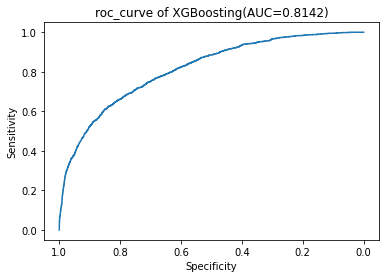

In [165]:
my_xgb_fpr,my_xgb_tpr,my_xgb_threasholds=roc_curve(y_train,y_predprob_train)
plt.title("roc_curve of %s(AUC=%.4f)"%('XGBoosting',roc_auc_score(y_train,y_predprob_train)))
plt.xlabel('Specificity')
plt.ylabel('Sensitivity')
plt.plot(list(1-np.array(my_xgb_fpr)),my_xgb_tpr)
plt.gca().invert_xaxis()
plt.show()

In [163]:
# 模型存储
joblib.dump(my_xgb, 'XGBoosting.pkl')
# 模型加载
my_model = joblib.load('XGBoosting.pkl')
!cp /content/XGBoosting.pkl /content/drive/MyDrive/MFE\ project/Credit_Card_Default/data/model/Tree/

In [ ]:
digraph = xgboost.to_graphviz(my_xgb, num_trees=0)
digraph.save()
!dot -Tpng Digraph.gv >XGBoosting_1.png
!cp /content/XGBoosting_1.png /content/drive/MyDrive/MFE\ project/Credit_Card_Default/data/model/Tree/pictures/

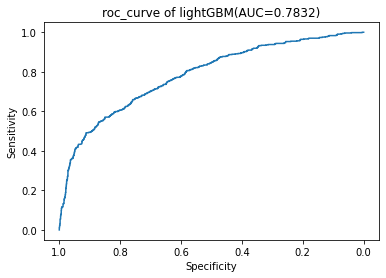

In [ ]:
my_xgb_fpr,my_xgb_tpr,my_xgb_threasholds=roc_curve(y_test,y_pred)
plt.title("roc_curve of %s(AUC=%.4f)"%('lightGBM',roc_auc_score(y_test,y_pred)))
plt.xlabel('Specificity')
plt.ylabel('Sensitivity')
plt.plot(list(1-np.array(my_xgb_fpr)),my_xgb_tpr)
plt.gca().invert_xaxis()
plt.show()

In [ ]:
n_lr_list=[]
for n_lr in [i*0.01 for i in range(1,100)]:
  my_xgb = XGBClassifier(
      objective='binary:logistic',
      n_estimators=102, 
      learning_rate=n_lr,
      metric='auc',
      max_depth=3,
      min_child_weight=1,
      subsample=0.8,
      scale_pos_weight=4,#解决样本不平衡的问题
      random_state=2022
      )
  my_xgb.fit(X_train,y_train,eval_metric='auc')
  #print("Validation:",my_xgb.score(X_valid_xgb,y_valid))

  y_pred = my_xgb.predict_proba(X_test)[:,1]
  n_lr_list.append(roc_auc_score(y_test,y_pred))

In [ ]:
n_lr_list

[0.7685454723161826,
 0.773530665360793,
 0.7764955831038481,
 0.77743115697791,
 0.7800837129536424,
 0.781188062943919,
 0.7808661287998557,
 0.7800978196141022,
 0.7793622580329875,
 0.7798595178141932,
 0.7779334548521369,
 0.7791300019447038,
 0.7752904712531451,
 0.774191663165192,
 0.7777782815870798,
 0.7735563596352018,
 0.7732827911841433,
 0.7748385543091314,
 0.7725724200681351,
 0.7711491587896083,
 0.7749131180858471,
 0.7692815377065997,
 0.7736752586305053,
 0.7738616680722946,
 0.7648963815408303,
 0.770884155096686,
 0.7689399549997532,
 0.7622402988999827,
 0.7613137935933594,
 0.7658934201497523,
 0.7641683770992473,
 0.767225491944593,
 0.7656374850242685,
 0.7614906306584084,
 0.7615107830304935,
 0.758782655659441,
 0.7564399424045206,
 0.7613520831003215,
 0.7562268310697181,
 0.7614170745002967,
 0.7543209204797473,
 0.7625158825882498,
 0.7572107706367848,
 0.7565749632974925,
 0.7631285146996439,
 0.7576808247156752,
 0.7499579319232719,
 0.7566968851486087,


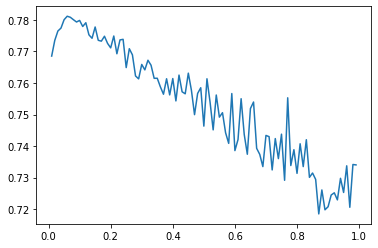

In [ ]:
x=[i*0.01 for i in range(1,100)]
plt.plot(x,n_lr_list)

In [ ]:
n_lr_list[100:150]

[0.7834718305104899,
 0.7837882227522296,
 0.7836280113941512,
 0.7832884439245132,
 0.7830335164176337,
 0.783200781105942,
 0.7831161411431836,
 0.7829186478967473,
 0.7830163869013611,
 0.7834541971849152,
 0.7835700733244058,
 0.7835287609616309,
 0.7835610047569674,
 0.7837010637429606,
 0.7833695572221567,
 0.7834068391105147,
 0.7833584734175097,
 0.7834259838639956,
 0.7830571954548341,
 0.7830753325897108,
 0.7831801249245546,
 0.7829806164409097,
 0.7830662640222724,
 0.7828466031665422,
 0.782633995641042,
 0.7829352736037177,
 0.7829090755200068,
 0.7829352736037177,
 0.7829131059944239,
 0.7823387633899916,
 0.7819780359296642,
 0.7819135483389911,
 0.7815165466089099,
 0.78128983242295,
 0.7813704419112913,
 0.7817946493436876,
 0.7818883578738846,
 0.7821029806365933,
 0.7820969349249677,
 0.7816374608414219,
 0.781581034199583,
 0.7811800019950847,
 0.7812676648136562,
 0.7812737105252817,
 0.7813336638322357,
 0.781161361050906,
 0.7812339095904132,
 0.7811271020183608

In [ ]:
max(n_lr_list)

0.5276265650517147

#random forest代码

In [151]:
rf0 = RandomForestClassifier(n_estimators=150,
                             max_depth=18,
                             min_samples_split=82,
                             oob_score=True, 
                             random_state=2022,
                             min_weight_fraction_leaf=0.0,
                             min_samples_leaf=1,
                             max_features='auto'
                             )
rf0.fit(X_train,y_train)
y_pred=rf0.predict(X_test)
y_predprob = rf0.predict_proba(X_test)[:,1]
roc_auc_score(y_test,y_predprob)

0.7897241039499656

In [155]:
y_predprob_train = rf0.predict_proba(X_train)[:,1]
roc_auc_score(y_train,y_predprob_train)

0.8922546496970297

In [158]:
rf0_fi = pd.DataFrame(columns = ['feature', 'importance'])
rf0_fi['feature'] = X_train.columns
rf0_fi['importance'] = rf0.feature_importances_
rf0_fi.sort_values(by='importance', ascending=False, inplace=True)
rf0_fi.reset_index(drop=True)

feature  importance
0       PAY_0    0.232145
1       PAY_2    0.109374
2       PAY_3    0.058913
3    PAY_AMT1    0.051045
4       PAY_4    0.048733
5   LIMIT_BAL    0.044846
6       PAY_5    0.043039
7    PAY_AMT3    0.040640
8   BILL_AMT1    0.036794
9    PAY_AMT2    0.036036
10  BILL_AMT2    0.034198
11      PAY_6    0.033316
12  BILL_AMT4    0.030623
13  BILL_AMT6    0.029652
14   PAY_AMT5    0.029093
15  BILL_AMT5    0.028329
16  BILL_AMT3    0.026495
17   PAY_AMT6    0.025856
18        AGE    0.025214
19   PAY_AMT4    0.022687
20  EDUCATION    0.005909
21   MARRIAGE    0.004275
22        SEX    0.002789

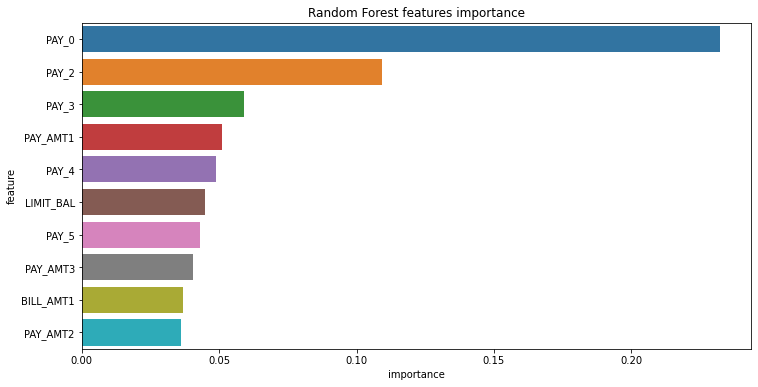

In [160]:
%matplotlib inline
def feature_importances(df, model):
    max_num_features=10
    feature_importances = pd.DataFrame(columns = ['feature', 'importance'])
    feature_importances['feature'] = df.columns
    feature_importances['importance'] = model.feature_importances_
    feature_importances.sort_values(by='importance', ascending=False, inplace=True)
    feature_importances = feature_importances[:max_num_features]
    plt.figure(figsize=(12, 6));
    sns.barplot(x="importance", y="feature", data=feature_importances);
    plt.title('Random Forest features importance');
feature_importances(X_train, rf0)

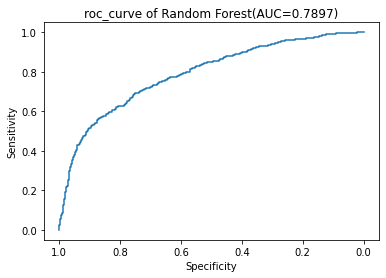

In [156]:
rf0_fpr,rf0_tpr,rf0_threasholds=roc_curve(y_test,y_predprob)
plt.title("roc_curve of %s(AUC=%.4f)"%('Random Forest',roc_auc_score(y_test,y_predprob)))
plt.xlabel('Specificity')
plt.ylabel('Sensitivity')
plt.plot(list(1-np.array(rf0_fpr)),rf0_tpr)
plt.gca().invert_xaxis()
plt.show()

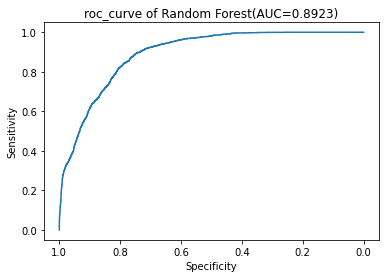

In [157]:
rf0_fpr,rf0_tpr,rf0_threasholds=roc_curve(y_train,y_predprob_train)
plt.title("roc_curve of %s(AUC=%.4f)"%('Random Forest',roc_auc_score(y_train,y_predprob_train)))
plt.xlabel('Specificity')
plt.ylabel('Sensitivity')
plt.plot(list(1-np.array(rf0_fpr)),rf0_tpr)
plt.gca().invert_xaxis()
plt.show()

In [153]:
# 模型存储
joblib.dump(rf0, 'Random_forest.pkl')
# 模型加载
my_model = joblib.load('Random_forest.pkl')

In [154]:
!cp /content/Random_forest.pkl /content/drive/MyDrive/MFE\ project/Credit_Card_Default/data/model/Tree/

In [81]:
rf0.estimators_[1]

DecisionTreeClassifier(max_depth=18, max_features='auto', min_samples_split=82,
                       random_state=1642857692)

[Text(0.598338895631068, 0.9736842105263158, 'PAY_3 <= 1.0\ngini = 0.341\nsamples = 4869\nvalue = [6006, 1674]'),
 Text(0.26463895631067963, 0.9210526315789473, 'PAY_AMT1 <= 106.0\ngini = 0.287\nsamples = 4217\nvalue = [5506, 1156]'),
 Text(0.14563106796116504, 0.868421052631579, 'PAY_AMT2 <= 10895.5\ngini = 0.436\nsamples = 700\nvalue = [760, 360]'),
 Text(0.13592233009708737, 0.8157894736842105, 'PAY_2 <= 0.5\ngini = 0.445\nsamples = 665\nvalue = [703, 354]'),
 Text(0.10679611650485436, 0.7631578947368421, 'PAY_0 <= 0.5\ngini = 0.407\nsamples = 466\nvalue = [539, 214]'),
 Text(0.07766990291262135, 0.7105263157894737, 'BILL_AMT2 <= 52.5\ngini = 0.351\nsamples = 262\nvalue = [327, 96]'),
 Text(0.06796116504854369, 0.6578947368421053, 'LIMIT_BAL <= 295000.0\ngini = 0.345\nsamples = 259\nvalue = [327, 93]'),
 Text(0.05825242718446602, 0.6052631578947368, 'PAY_AMT4 <= 2465.0\ngini = 0.303\nsamples = 193\nvalue = [258, 59]'),
 Text(0.04854368932038835, 0.5526315789473685, 'PAY_AMT3 <= 2064

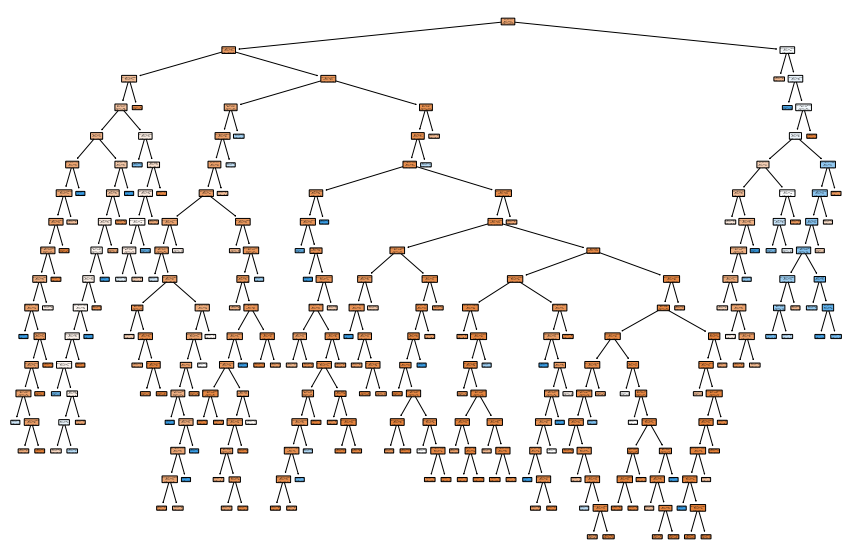

In [85]:

fig = plt.figure(figsize=(15, 10))
plot_tree(rf0.estimators_[0], 
          feature_names=X_train.columns,
          filled=True, impurity=True, 
          rounded=True)

In [76]:
y_predprob = rf0.predict_proba(X_train)[:,1]
roc_auc_score(y_train,y_predprob)

0.8922546496970297

In [69]:
n_lr_list=[]
for n_lr in [i for i in range(3,24,1)]:
  rf0 = RandomForestClassifier(
      n_estimators=150,
      max_depth=18,
      min_samples_split=82,
      oob_score=True, 
      random_state=2022,
      min_weight_fraction_leaf=0.0,
      min_samples_leaf=1,
      max_features=n_lr
      )
  rf0.fit(X_train,y_train)
  print(n_lr)
  #print("Validation:",my_xgb.score(X_valid_xgb,y_valid))

  y_predprob = rf0.predict_proba(X_test)[:,1]
  n_lr_list.append(roc_auc_score(y_test,y_predprob))

3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


In [70]:
n_lr_list

[0.7873592230857512,
 0.7897241039499656,
 0.7846043938216859,
 0.7865994786581342,
 0.7861329512443587,
 0.7886308377643362,
 0.7848270775332289,
 0.7872433469462605,
 0.7852215602167991,
 0.7843917862961856,
 0.7835615085662695,
 0.7851323859703216,
 0.7844310834217519,
 0.785243224016791,
 0.7845288224263658,
 0.7837579941941015,
 0.7845459519426383,
 0.7830244478501954,
 0.7845837376402982,
 0.7845197538589275,
 0.7820697292226525]

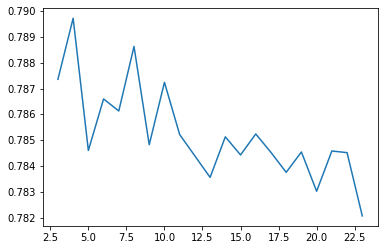

In [72]:
x=[i for i in range(3,24,1)]
plt.plot(x,n_lr_list, color='green')
#plt.plot(x,n_lr_list_train,color='red')

In [25]:
n_lr_list[10:20]

[0.7847268194821041,
 0.784805413733237,
 0.784744956616981,
 0.7846804690263078,
 0.7850522802912824,
 0.784458289124067,
 0.7846860109286313,
 0.7844058929566451,
 0.7844109310496664,
 0.7841751482962681]

In [ ]:
y_predprob 

array([0.  , 0.  , 0.41, ..., 0.19, 0.31, 0.9 ])

0.4952892915467766

#Adaboosting(删除）

In [46]:
#AdaBoostClassifier

sklearn.ensemble._weight_boosting.AdaBoostClassifier

In [107]:
rf0 = AdaBoostClassifier(n_estimators=46,
                         learning_rate=0.4)
rf0.fit(X_train,y_train)
y_pred=rf0.predict(X_test)
y_predprob = rf0.predict_proba(X_test)[:,1]
roc_auc_score(y_test,y_predprob)

0.777193358987303

In [108]:
y_predprob_train = rf0.predict_proba(X_train)[:,1]
roc_auc_score(y_train,y_predprob_train)

0.7806786574879725

In [104]:
n_lr_list=[]
n_lr_list_train=[]
for n_lr in [i*0.01 for i in range(1,100,5)]:
  rf0 = AdaBoostClassifier(
      n_estimators=46,
      learning_rate=n_lr
      )
  rf0.fit(X_train,y_train)
  print(n_lr)
  #print("Validation:",my_xgb.score(X_valid_xgb,y_valid))

  y_predprob = rf0.predict_proba(X_test)[:,1]
  n_lr_list.append(roc_auc_score(y_test,y_predprob))

  y_predprob_train = rf0.predict_proba(X_train)[:,1]
  n_lr_list_train.append(roc_auc_score(y_train,y_predprob_train))

0.01
0.06
0.11
0.16
0.21
0.26
0.31
0.36
0.41000000000000003
0.46
0.51
0.56
0.61
0.66
0.71
0.76
0.81
0.86
0.91
0.96


In [105]:
n_lr_list

[0.705736574237812,
 0.7675983108281719,
 0.7697233784645706,
 0.7715214738638848,
 0.7745372763464555,
 0.774648618202227,
 0.7747735629091561,
 0.7752486550810679,
 0.7782070233031955,
 0.7782483356659704,
 0.7768427077130181,
 0.7759645680993996,
 0.7768633638944057,
 0.7705864037991252,
 0.7693888490879541,
 0.7716988147382358,
 0.7699934202505141,
 0.7715139167243528,
 0.7712121349523748,
 0.7697465536924688]

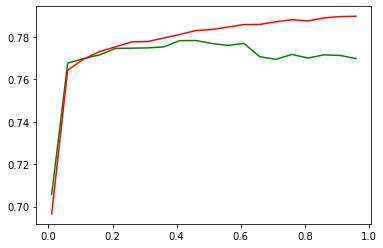

In [106]:
x=[i*0.01 for i in range(1,100,5)]
plt.plot(x,n_lr_list, color='green')
plt.plot(x,n_lr_list_train,color='red')

#Decision Tree

In [144]:
dt0=DecisionTreeClassifier(
    max_depth=5,
    class_weight='balanced',
    splitter='random',
    random_state=2022
    #min_samples_split=2)
)
dt0.fit(X_train,y_train)
y_pred=dt0.predict(X_test)
y_predprob = dt0.predict_proba(X_test)[:,1]
roc_auc_score(y_test,y_predprob)

0.7483336507331937

In [145]:
y_predprob_train = dt0.predict_proba(X_train)[:,1]
roc_auc_score(y_train,y_predprob_train)

0.7479640531330939

In [146]:
# 模型存储
joblib.dump(dt0, 'DecisionTree.pkl')
# 模型加载
my_model = joblib.load('DecisionTree.pkl')
!cp /content/DecisionTree.pkl /content/drive/MyDrive/MFE\ project/Credit_Card_Default/data/model/Tree/

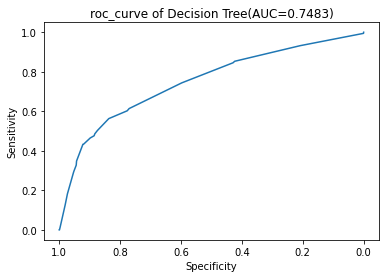

In [147]:
dt0_fpr,dt0_tpr,dt0_threasholds=roc_curve(y_test,y_predprob)
plt.title("roc_curve of %s(AUC=%.4f)"%('Decision Tree',roc_auc_score(y_test,y_predprob)))
plt.xlabel('Specificity')
plt.ylabel('Sensitivity')
plt.plot(list(1-np.array(dt0_fpr)),dt0_tpr)
plt.gca().invert_xaxis()
plt.show()

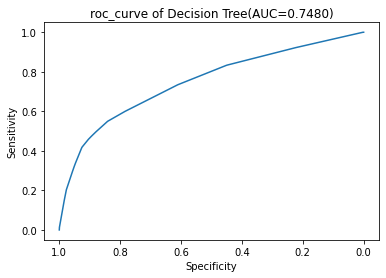

In [148]:
dt0_fpr,dt0_tpr,dt0_threasholds=roc_curve(y_train,y_predprob_train)
plt.title("roc_curve of %s(AUC=%.4f)"%('Decision Tree',roc_auc_score(y_train,y_predprob_train)))
plt.xlabel('Specificity')
plt.ylabel('Sensitivity')
plt.plot(list(1-np.array(dt0_fpr)),dt0_tpr)
plt.gca().invert_xaxis()
plt.show()

In [149]:
dt0_fi = pd.DataFrame(columns = ['feature', 'importance'])
dt0_fi['feature'] = X_train.columns
dt0_fi['importance'] = dt0.feature_importances_
dt0_fi.sort_values(by='importance', ascending=False, inplace=True)
dt0_fi.reset_index(drop=True)

feature  importance
0       PAY_0    0.344309
1       PAY_3    0.325745
2       PAY_2    0.148157
3   LIMIT_BAL    0.132654
4   BILL_AMT5    0.013627
5       PAY_6    0.011224
6         SEX    0.005787
7    PAY_AMT1    0.005630
8   BILL_AMT6    0.004126
9    PAY_AMT6    0.003705
10   PAY_AMT5    0.002874
11  BILL_AMT3    0.002162
12      PAY_5    0.000000
13      PAY_4    0.000000
14  BILL_AMT2    0.000000
15  BILL_AMT4    0.000000
16        AGE    0.000000
17   MARRIAGE    0.000000
18  EDUCATION    0.000000
19   PAY_AMT2    0.000000
20   PAY_AMT3    0.000000
21   PAY_AMT4    0.000000
22  BILL_AMT1    0.000000

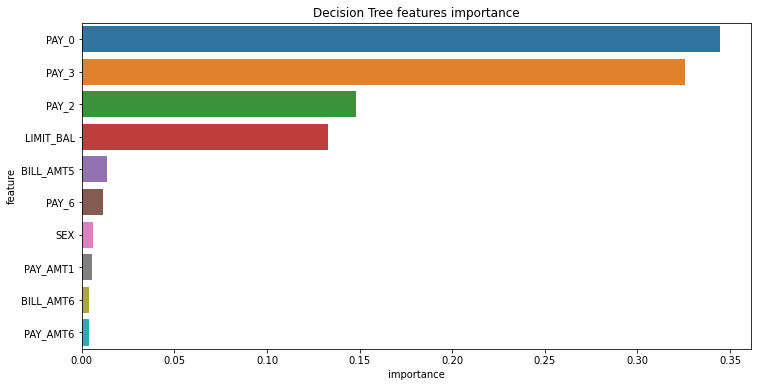

In [159]:
%matplotlib inline
def feature_importances(df, model):
    max_num_features=10
    feature_importances = pd.DataFrame(columns = ['feature', 'importance'])
    feature_importances['feature'] = df.columns
    feature_importances['importance'] = model.feature_importances_
    feature_importances.sort_values(by='importance', ascending=False, inplace=True)
    feature_importances = feature_importances[:max_num_features]
    plt.figure(figsize=(12, 6));
    sns.barplot(x="importance", y="feature", data=feature_importances);
    plt.title('Decision Tree features importance');
feature_importances(X_train, dt0)

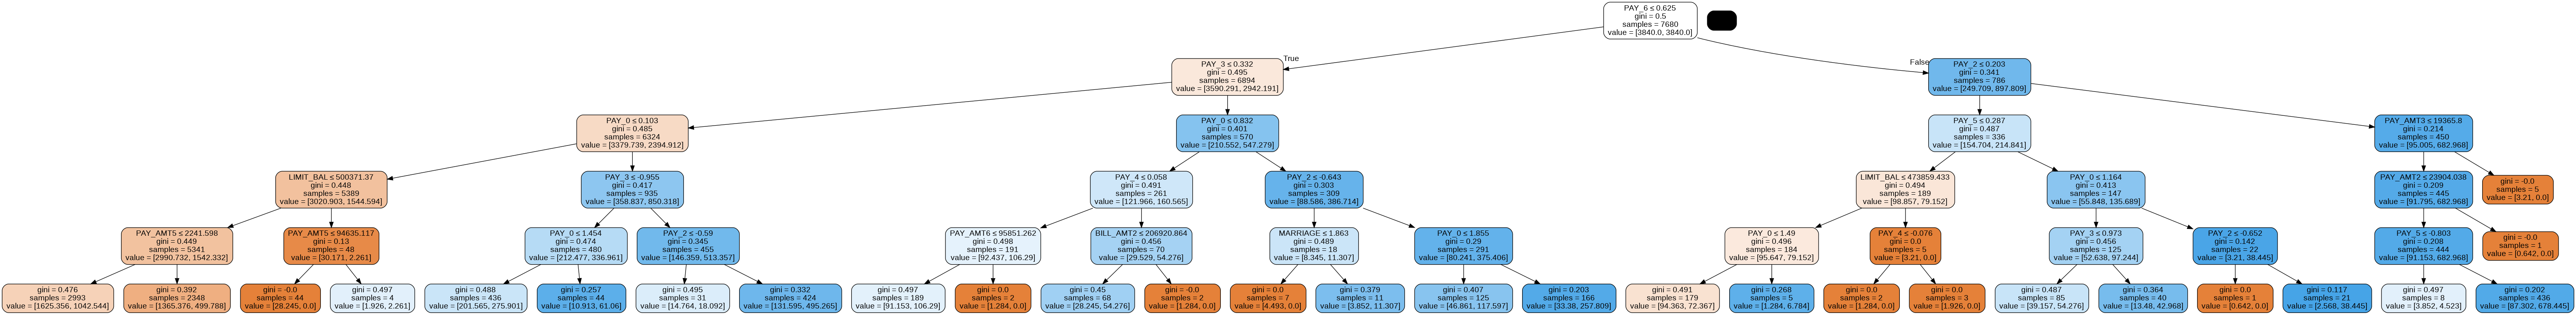

In [163]:
dot_data = export_graphviz(dt0,out_file=None,feature_names=X_train.columns,filled=True,rounded=True,special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_png('DecisionTree.png')
display(Image(graph.create_png()))

In [145]:
n_lr_list=[]
n_lr_list_train=[]
for n_lr in [i for i in range(1,20,1)]:
  dt0 = DecisionTreeClassifier(
      max_depth=n_lr,
      class_weight='balanced',
      splitter='random'
      )
  dt0.fit(X_train,y_train)
  print(n_lr)
  #print("Validation:",my_xgb.score(X_valid_xgb,y_valid))

  y_predprob = dt0.predict_proba(X_test)[:,1]
  n_lr_list.append(roc_auc_score(y_test,y_predprob))

  y_predprob_train = dt0.predict_proba(X_train)[:,1]
  n_lr_list_train.append(roc_auc_score(y_train,y_predprob_train))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [146]:
n_lr_list

[0.6463122670511738,
 0.6387989589284581,
 0.7097368200967515,
 0.6921866230569336,
 0.7476912938729735,
 0.7501745699231893,
 0.7520885414619942,
 0.7469290303988456,
 0.7232726646171705,
 0.6964115678646244,
 0.724068179505239,
 0.7074409611069294,
 0.662986843523884,
 0.6950593436976984,
 0.6312977422289934,
 0.653867895155269,
 0.6233441047762129,
 0.6403743706162294,
 0.6179190862108401]

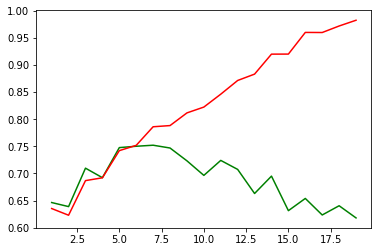

In [147]:
x=[i for i in range(1,20,1)]
plt.plot(x,n_lr_list, color='green')
plt.plot(x,n_lr_list_train,color='red')

#GBDT

In [126]:
gbdt=GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.06,
    random_state=2022,
    subsample=0.5
)
gbdt.fit(X_train,y_train)
y_pred=gbdt.predict(X_test)
y_predprob = gbdt.predict_proba(X_test)[:,1]
roc_auc_score(y_test,y_predprob)

0.790159395187009

In [127]:
y_predprob_train = gbdt.predict_proba(X_train)[:,1]
roc_auc_score(y_train,y_predprob_train)

0.8138618840423901

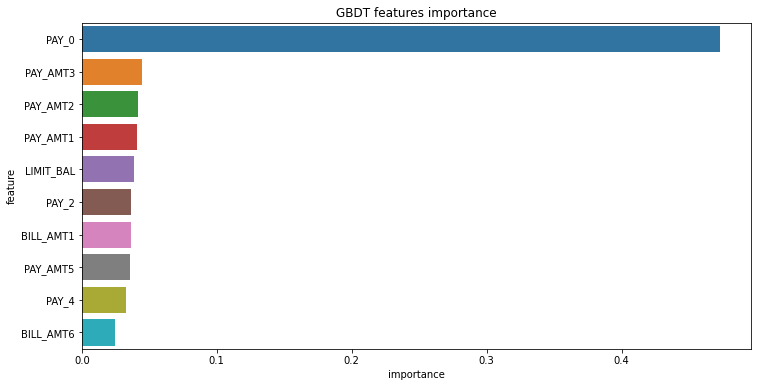

In [132]:
%matplotlib inline
def feature_importances(df, model):
    max_num_features=10
    feature_importances = pd.DataFrame(columns = ['feature', 'importance'])
    feature_importances['feature'] = df.columns
    feature_importances['importance'] = model.feature_importances_
    feature_importances.sort_values(by='importance', ascending=False, inplace=True)
    feature_importances = feature_importances[:max_num_features]
    plt.figure(figsize=(12, 6));
    sns.barplot(x="importance", y="feature", data=feature_importances);
    plt.title('GBDT features importance');
feature_importances(X_train, gbdt)

In [131]:
gbdt_fi = pd.DataFrame(columns = ['feature', 'importance'])
gbdt_fi['feature'] = X_train.columns
gbdt_fi['importance'] = gbdt.feature_importances_
gbdt_fi.sort_values(by='importance', ascending=False, inplace=True)
gbdt_fi.reset_index(drop=True)

feature  importance
0       PAY_0    0.472665
1    PAY_AMT3    0.044378
2    PAY_AMT2    0.041456
3    PAY_AMT1    0.040536
4   LIMIT_BAL    0.038779
5       PAY_2    0.036704
6   BILL_AMT1    0.036627
7    PAY_AMT5    0.035771
8       PAY_4    0.032611
9   BILL_AMT6    0.024522
10  BILL_AMT4    0.023766
11      PAY_3    0.023218
12        AGE    0.022442
13      PAY_6    0.019404
14  BILL_AMT5    0.018475
15   PAY_AMT6    0.016735
16  BILL_AMT2    0.016579
17  BILL_AMT3    0.014410
18   PAY_AMT4    0.013340
19      PAY_5    0.012749
20  EDUCATION    0.006018
21   MARRIAGE    0.004827
22        SEX    0.003989

In [25]:
# 模型存储
joblib.dump(gbdt, 'GBDT.pkl')
# 模型加载
my_model = joblib.load('GBDT.pkl')
!cp /content/GBDT.pkl /content/drive/MyDrive/MFE\ project/Credit_Card_Default/data/model/Tree/

In [71]:
gbdt.estimators_[0]

array([DecisionTreeRegressor(criterion='friedman_mse', max_depth=19,
                             random_state=RandomState(MT19937) at 0x7FA8EF692380)],
      dtype=object)

In [73]:
dot_data = export_graphviz(gbdt.estimators_[0,0],out_file=None,feature_names=X_train.columns,filled=True,rounded=True,special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_png('GradientBoostingDecisionTree.png')
display(Image(graph.create_png()))

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.757181 to fit

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.757181 to fit



In [74]:
!cp /content/GradientBoostingDecisionTree.png /content/drive/MyDrive/MFE\ project/Credit_Card_Default/data/model/Tree/pictures/

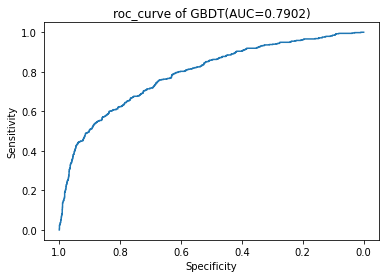

In [128]:
gbdt_fpr,gbdt_tpr,gbdt_threasholds=roc_curve(y_test,y_predprob)
plt.title("roc_curve of %s(AUC=%.4f)"%('GBDT',roc_auc_score(y_test,y_predprob)))
plt.xlabel('Specificity')
plt.ylabel('Sensitivity')
plt.plot(list(1-np.array(gbdt_fpr)),gbdt_tpr)
plt.gca().invert_xaxis()
plt.show()

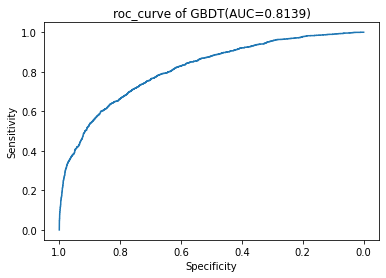

In [129]:
gbdt_fpr,gbdt_tpr,gbdt_threasholds=roc_curve(y_train,y_predprob_train)
plt.title("roc_curve of %s(AUC=%.4f)"%('GBDT',roc_auc_score(y_train,y_predprob_train)))
plt.xlabel('Specificity')
plt.ylabel('Sensitivity')
plt.plot(list(1-np.array(gbdt_fpr)),gbdt_tpr)
plt.gca().invert_xaxis()
plt.show()

In [66]:
n_lr_list=[]
n_lr_list_train=[]
for n_lr in [i for i in range(3,21,2)]:
  gbdt = GradientBoostingClassifier(
      n_estimators=100,
      learning_rate=0.06,
      random_state=2022,
      subsample=0.5,
      max_depth=n_lr
      )
  gbdt.fit(X_train,y_train)
  print(n_lr)
  #print("Validation:",my_xgb.score(X_valid_xgb,y_valid))

  y_predprob = gbdt.predict_proba(X_test)[:,1]
  n_lr_list.append(roc_auc_score(y_test,y_predprob))

  y_predprob_train = gbdt.predict_proba(X_train)[:,1]
  n_lr_list_train.append(roc_auc_score(y_train,y_predprob_train))

3
5
7
9
11
13
15
17
19


In [67]:
n_lr_list

[0.790159395187009,
 0.783204307771057,
 0.7779828281637461,
 0.771001542664083,
 0.7659967010566896,
 0.7588778756175443,
 0.7682376448325792,
 0.7701883944504397,
 0.7635340811878614]

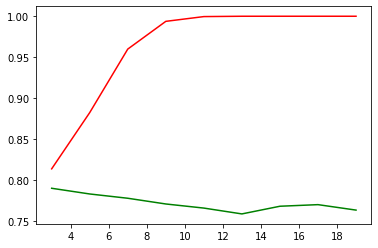

In [69]:
x=[i for i in range(3,21,2)]
plt.plot(x,n_lr_list, color='green')
plt.plot(x,n_lr_list_train,color='red')

#CatBoost

In [20]:
from catboost import CatBoostClassifier

In [88]:
catboost=CatBoostClassifier(
    iterations=340,
    learning_rate=0.05,
    depth=3,
    l2_leaf_reg=8,
    random_strength=1.5
)
catboost.fit(X_train,y_train)
y_pred=catboost.predict(X_test)
y_predprob = catboost.predict_proba(X_test)[:,1]
roc_auc_score(y_test,y_predprob)

0:	learn: 0.6676512	total: 4.73ms	remaining: 1.6s
1:	learn: 0.6437169	total: 17.7ms	remaining: 3s
2:	learn: 0.6231299	total: 22.3ms	remaining: 2.51s
3:	learn: 0.6045951	total: 30.7ms	remaining: 2.58s
4:	learn: 0.5904257	total: 45.8ms	remaining: 3.07s
5:	learn: 0.5748609	total: 51ms	remaining: 2.84s
6:	learn: 0.5613444	total: 59.3ms	remaining: 2.82s
7:	learn: 0.5493774	total: 74.7ms	remaining: 3.1s
8:	learn: 0.5385555	total: 83.4ms	remaining: 3.07s
9:	learn: 0.5294341	total: 102ms	remaining: 3.37s
10:	learn: 0.5215339	total: 110ms	remaining: 3.29s
11:	learn: 0.5136769	total: 123ms	remaining: 3.36s
12:	learn: 0.5072045	total: 131ms	remaining: 3.31s
13:	learn: 0.5006258	total: 141ms	remaining: 3.28s
14:	learn: 0.4949664	total: 146ms	remaining: 3.16s
15:	learn: 0.4897868	total: 154ms	remaining: 3.12s
16:	learn: 0.4852502	total: 164ms	remaining: 3.11s
17:	learn: 0.4815436	total: 171ms	remaining: 3.06s
18:	learn: 0.4784012	total: 182ms	remaining: 3.07s
19:	learn: 0.4752483	total: 190ms	remai

0.7880706018203638

In [89]:
y_predprob_train = catboost.predict_proba(X_train)[:,1]
roc_auc_score(y_train,y_predprob_train)

0.8104220888027254

In [125]:
# 模型存储
joblib.dump(catboost, 'CatBoost.pkl')
# 模型加载
my_model = joblib.load('CatBoost.pkl')
!cp /content/CatBoost.pkl /content/drive/MyDrive/MFE\ project/Credit_Card_Default/data/model/Tree/

特征重要性

In [112]:
for i,j in zip(X_train.columns,catboost.feature_importances_):
  print('{}: {:.2f}%'.format(i,j))

LIMIT_BAL: 6.81%
SEX: 0.88%
EDUCATION: 2.20%
MARRIAGE: 1.45%
AGE: 1.71%
PAY_0: 30.74%
PAY_2: 5.43%
PAY_3: 2.39%
PAY_4: 3.56%
PAY_5: 1.32%
PAY_6: 2.93%
BILL_AMT1: 4.48%
BILL_AMT2: 4.98%
BILL_AMT3: 2.42%
BILL_AMT4: 2.92%
BILL_AMT5: 2.46%
BILL_AMT6: 1.50%
PAY_AMT1: 5.35%
PAY_AMT2: 5.48%
PAY_AMT3: 4.74%
PAY_AMT4: 2.00%
PAY_AMT5: 2.51%
PAY_AMT6: 1.75%


In [124]:
catboost_fi = pd.DataFrame(columns = ['feature', 'importance'])
catboost_fi['feature'] = X_train.columns
catboost_fi['importance'] = catboost.feature_importances_
catboost_fi.sort_values(by='importance', ascending=False, inplace=True)
catboost_fi.reset_index(drop=True)

feature  importance
0       PAY_0   30.735518
1   LIMIT_BAL    6.805102
2    PAY_AMT2    5.483745
3       PAY_2    5.426373
4    PAY_AMT1    5.352305
5   BILL_AMT2    4.975385
6    PAY_AMT3    4.737673
7   BILL_AMT1    4.480738
8       PAY_4    3.563091
9       PAY_6    2.926519
10  BILL_AMT4    2.919894
11   PAY_AMT5    2.509360
12  BILL_AMT5    2.457834
13  BILL_AMT3    2.417974
14      PAY_3    2.388991
15  EDUCATION    2.200454
16   PAY_AMT4    2.004100
17   PAY_AMT6    1.749890
18        AGE    1.710573
19  BILL_AMT6    1.499572
20   MARRIAGE    1.451641
21      PAY_5    1.321332
22        SEX    0.881936

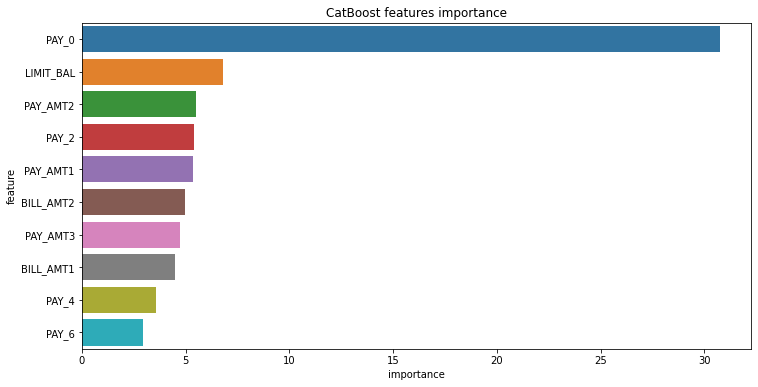

In [116]:
%matplotlib inline
def feature_importances(df, model):
    max_num_features=10
    feature_importances = pd.DataFrame(columns = ['feature', 'importance'])
    feature_importances['feature'] = df.columns
    feature_importances['importance'] = model.feature_importances_
    feature_importances.sort_values(by='importance', ascending=False, inplace=True)
    feature_importances = feature_importances[:max_num_features]
    plt.figure(figsize=(12, 6));
    sns.barplot(x="importance", y="feature", data=feature_importances);
    plt.title('CatBoost features importance');
feature_importances(X_train, catboost)

In [111]:
cat_tree=catboost.plot_tree(tree_idx=0,pool=X_train)

In [100]:
cat_tree.save()

'Digraph.gv'

In [102]:
!dot -Tpng Digraph.gv >CatBoost.png
!cp /content/CatBoost.png /content/drive/MyDrive/MFE\ project/Credit_Card_Default/data/model/Tree/pictures/

(-0.5, 1116.5, 406.5, -0.5)

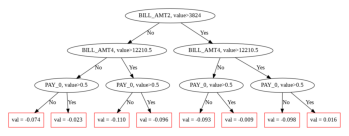

In [106]:
lena=mpimg.imread('CatBoost.png')
plt.imshow(lena)
plt.axis('off')

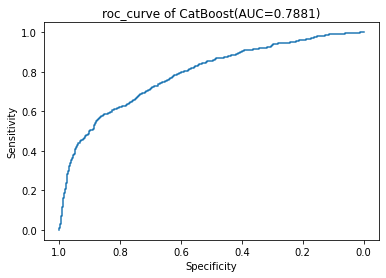

In [92]:
catboost_fpr,catboost_tpr,catboost_threasholds=roc_curve(y_test,y_predprob)
plt.title("roc_curve of %s(AUC=%.4f)"%('CatBoost',roc_auc_score(y_test,y_predprob)))
plt.xlabel('Specificity')
plt.ylabel('Sensitivity')
plt.plot(list(1-np.array(catboost_fpr)),catboost_tpr)
plt.gca().invert_xaxis()
plt.show()

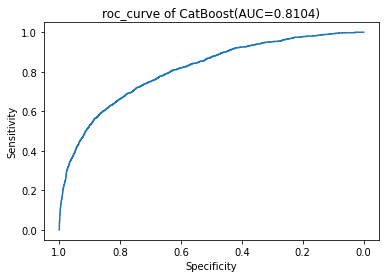

In [93]:
catboost_fpr,catboost_tpr,catboost_threasholds=roc_curve(y_train,y_predprob_train)
plt.title("roc_curve of %s(AUC=%.4f)"%('CatBoost',roc_auc_score(y_train,y_predprob_train)))
plt.xlabel('Specificity')
plt.ylabel('Sensitivity')
plt.plot(list(1-np.array(catboost_fpr)),catboost_tpr)
plt.gca().invert_xaxis()
plt.show()

In [77]:
n_lr_list=[]
n_lr_list_train=[]
for n_lr in [i*0.1 for i in range(5,20,1)]:
  catboost=CatBoostClassifier(
      iterations=340,
      learning_rate=0.05,
      depth=3,
      l2_leaf_reg=8,
      random_strength=n_lr
      )
  catboost.fit(X_train,y_train)
  print(n_lr)
  #print("Validation:",my_xgb.score(X_valid_xgb,y_valid))

  y_predprob = catboost.predict_proba(X_test)[:,1]
  n_lr_list.append(roc_auc_score(y_test,y_predprob))

  y_predprob_train = catboost.predict_proba(X_train)[:,1]
  n_lr_list_train.append(roc_auc_score(y_train,y_predprob_train))

Streaming output truncated to the last 5000 lines.
115:	learn: 0.4244157	total: 833ms	remaining: 1.61s
116:	learn: 0.4242395	total: 846ms	remaining: 1.61s
117:	learn: 0.4241529	total: 863ms	remaining: 1.62s
118:	learn: 0.4240185	total: 870ms	remaining: 1.62s
119:	learn: 0.4238957	total: 885ms	remaining: 1.62s
120:	learn: 0.4238066	total: 898ms	remaining: 1.63s
121:	learn: 0.4236599	total: 907ms	remaining: 1.62s
122:	learn: 0.4236406	total: 916ms	remaining: 1.61s
123:	learn: 0.4235099	total: 924ms	remaining: 1.61s
124:	learn: 0.4234115	total: 933ms	remaining: 1.6s
125:	learn: 0.4233427	total: 947ms	remaining: 1.61s
126:	learn: 0.4232624	total: 953ms	remaining: 1.6s
127:	learn: 0.4231879	total: 965ms	remaining: 1.6s
128:	learn: 0.4230728	total: 975ms	remaining: 1.59s
129:	learn: 0.4230063	total: 986ms	remaining: 1.59s
130:	learn: 0.4229321	total: 991ms	remaining: 1.58s
131:	learn: 0.4228497	total: 994ms	remaining: 1.57s
132:	learn: 0.4227489	total: 998ms	remaining: 1.55s
133:	learn: 0.42

In [78]:
n_lr_list

[0.787554197285677,
 0.7860724941281025,
 0.7859087561049092,
 0.7853248411237366,
 0.7857243619003283,
 0.7869304813696357,
 0.7861097760164604,
 0.7838315503522132,
 0.7848981146448295,
 0.7870020222905388,
 0.7880706018203638,
 0.7848175051564883,
 0.7879008180855448,
 0.7850119755471118,
 0.7831599725524692]

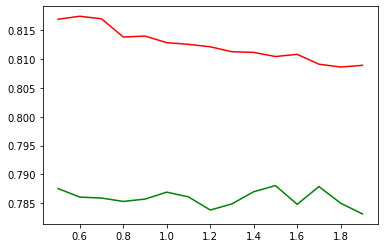

In [79]:
x=[i*0.1 for i in range(5,20,1)]
plt.plot(x,n_lr_list, color='green')
plt.plot(x,n_lr_list_train,color='red')

#linear regression

#SVM

In [ ]:
X_train_svm=X_train.drop(columns=['Company'])
X_test_svm=X_test.drop(columns=['Company'])
X_valid_svm=X_valid.drop(columns=['Company'])

In [ ]:
X_train_svm['past_adjclose_change_percent']=X_train_svm['past_adjclose_change_percent'].fillna(0)
X_test_svm['past_adjclose_change_percent']=X_test_svm['past_adjclose_change_percent'].fillna(0)
X_valid_svm['past_adjclose_change_percent']=X_valid_svm['past_adjclose_change_percent'].fillna(0)

In [ ]:
clf = svm.SVC(C=16.0, kernel='poly', degree=9, gamma='auto', coef0=0.0, 
              shrinking=True, probability=True, tol=0.001, cache_size=200, 
              class_weight=None, verbose=False, max_iter=5, decision_function_shape='ovr', 
              break_ties=False, random_state=0)  # class 
clf.fit(X_train_svm, y_train)  # training the svc model
#y_pred=clf.predict(X_test_svm)
#roc_auc_score(y_test,y_pred)
y_pred=clf.predict(X_test_svm)
y_predprob = clf.predict_proba(X_test_svm)[:,1]
roc_auc_score(y_test,y_predprob)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


0.5334794696321642

In [ ]:
#y_predprob

In [ ]:
n_lr_list=[]
for n_lr in [2**i for i in range(-15,15)]:
  clf = svm.SVC(C=16, kernel='poly', degree=9, gamma='auto', coef0=0.0, 
              shrinking=True, probability=True, tol=0.001, cache_size=200, 
              class_weight=None, verbose=False, max_iter=5, decision_function_shape='ovr', 
              break_ties=False, random_state=0)  # class 
  clf.fit(X_train_svm, y_train)  # training the svc model
  y_pred=clf.predict(X_test_svm)
  y_predprob = clf.predict_proba(X_test_svm)[:,1]
  n_lr_list.append(roc_auc_score(y_test,y_predprob))

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider

In [ ]:
n_lr_list

[0.5,
 0.5,
 0.5,
 0.5068291987453664,
 0.5051371283407211,
 0.5018336703216941,
 0.5111125152292818,
 0.5069497368898566,
 0.5050370039142493,
 0.5228688726443217,
 0.5239384866630376,
 0.5231161054514348,
 0.520717331570625,
 0.5180531793555745,
 0.5174501646058531,
 0.4925619540140498,
 0.4925619540140498,
 0.4925619540140498,
 0.5076807424112812,
 0.5,
 0.5187903413951318,
 0.48013648028618083,
 0.4807420872540634,
 0.5102719884905513,
 0.48474350001296107,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5]

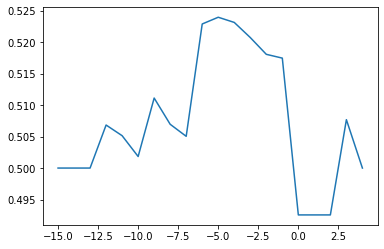

In [ ]:
x=[i for i in range(-15,5)]
plt.plot(x,n_lr_list)

In [ ]:
n_lr_list[15:25]

[0.5334794696321642,
 0.5267931669129274,
 0.524988010991005,
 0.5264775643518158,
 0.5218352256525909,
 0.5258625605930995,
 0.5276301293516863,
 0.5214512533374809,
 0.5202231899836691,
 0.5244008735775203]

In [ ]:
y_pred

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
roc_auc_score(y_test,y_pred)

0.5083116235062343

#KNN

In [ ]:
X_train_knn=X_train.drop(columns=['Company'])
X_test_knn=X_test.drop(columns=['Company'])
X_valid_knn=X_valid.drop(columns=['Company'])
X_train_knn['past_adjclose_change_percent']=X_train_knn['past_adjclose_change_percent'].fillna(0)
X_test_knn['past_adjclose_change_percent']=X_test_knn['past_adjclose_change_percent'].fillna(0)
X_valid_knn['past_adjclose_change_percent']=X_valid_knn['past_adjclose_change_percent'].fillna(0)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn = KNeighborsClassifier(n_neighbors=316,leaf_size=150)
knn.fit(X_train_knn,y_train)
y_predprob = knn.predict_proba(X_test_svm)[:,1]
roc_auc_score(y_test,y_predprob)

0.5249961116727583

In [ ]:
y_pred=knn.predict(X_test_knn)

In [ ]:
n_lr_list=[]
for n_lr in [i for i in range(1,300)]:
  knn = KNeighborsClassifier(n_neighbors=316, weights='uniform', 
                             algorithm='auto', leaf_size=n_lr, p=2, 
                             metric='minkowski', metric_params=None, n_jobs=None)
  knn.fit(X_train_knn,y_train)
  y_predprob = knn.predict_proba(X_test_svm)[:,1] 
  n_lr_list.append(roc_auc_score(y_test,y_predprob))

In [ ]:
n_lr_list

[0.5249789382274411,
 0.5249837986364932,
 0.5249837986364932,
 0.5250016201363507,
 0.5250016201363507,
 0.5250016201363507,
 0.5250016201363507,
 0.5249212613733573,
 0.5249212613733573,
 0.5249212613733573,
 0.5249212613733573,
 0.5249212613733573,
 0.5249212613733573,
 0.5249212613733573,
 0.5249212613733573,
 0.5248869144827227,
 0.5248869144827227,
 0.5248869144827227,
 0.5248869144827227,
 0.5248869144827227,
 0.5248869144827227,
 0.5248869144827227,
 0.5248869144827227,
 0.5248869144827227,
 0.5248869144827227,
 0.5248869144827227,
 0.5248869144827227,
 0.5248869144827227,
 0.5248869144827227,
 0.5248869144827227,
 0.5248869144827227,
 0.5249092723643621,
 0.5249092723643621,
 0.5249092723643621,
 0.5249092723643621,
 0.5249092723643621,
 0.5249092723643621,
 0.5249092723643621,
 0.5249092723643621,
 0.5249092723643621,
 0.5249092723643621,
 0.5249092723643621,
 0.5249092723643621,
 0.5249092723643621,
 0.5249092723643621,
 0.5249092723643621,
 0.5249092723643621,
 0.5249092723

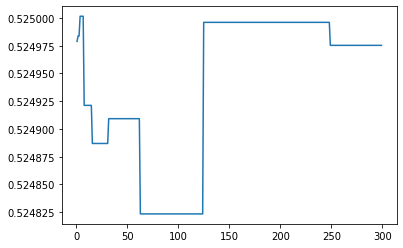

In [ ]:
x=[i for i in range(1,300)]
plt.plot(x,n_lr_list)

In [ ]:
n_lr_list[310:320]

[0.5241568810431088,
 0.5240574046711771,
 0.5242644580967935,
 0.5242732068330871,
 0.5248558078647899,
 0.5248869144827227,
 0.5242790393239495,
 0.5235059102574072,
 0.5234226352489826,
 0.5228144360629391]

#logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
X_train_lr=X_train.drop(columns=['Company'])
X_test_lr=X_test.drop(columns=['Company'])
X_valid_lr=X_valid.drop(columns=['Company'])
X_train_lr['past_adjclose_change_percent']=X_train_lr['past_adjclose_change_percent'].fillna(0)
X_test_lr['past_adjclose_change_percent']=X_test_lr['past_adjclose_change_percent'].fillna(0)
X_valid_lr['past_adjclose_change_percent']=X_valid_lr['past_adjclose_change_percent'].fillna(0)

In [ ]:
LR = LogisticRegression()
LR.fit(X_train_lr,y_train)
y_predprob=LR.predict_proba(X_test_lr)[:,1]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
roc_auc_score(y_test,y_predprob)

0.5084110998781657

ModuleNotFoundError: ignored